# Comparison of Smoothing Filters for P-ET Time Series

This notebook compares different smoothing filters (EMA and SMA) with various time scales (90, 180, 360 days) for P-ET time series in the Greater Horn of Africa. We extract representative grid points from each subregion to reduce computational time, as suggested by the supervisor.

In [1]:
import os
import time
import rasterio
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import datetime as dt
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy import stats, interpolate
from pandas import date_range, to_datetime
import dask
import logging
import dask.array as da
from joblib import Parallel, delayed
from dask import config as dask_config
from dask.diagnostics import ProgressBar
import warnings
# from helper_functions import * # Helper functions
from statsmodels.distributions.empirical_distribution import ECDF
from copulae import GaussianCopula, ClaytonCopula, FrankCopula, GumbelCopula, StudentCopula # Using Copulae Module

In [2]:
# Set dataset directory
dataset = '../../../datasets/'
output_dir = '../../datasets/results'

In [3]:
variables = xr.open_dataset(os.path.join(dataset, 'daily_dataset_combined'), chunks={'time': 500, 'y': 175, 'x': 148})

In [59]:
spei_3 =  xr.open_dataset(os.path.join(dataset, 'validation_datasets/spei03.nc'))

In [4]:
et_dir = "../../../datasets/et/lsa_saf"

In [5]:
'''
Study period: 2004 - 2024
'''
start_time = time.time()
import glob
# Find all NetCDF files in the directory
all_files = glob.glob(et_dir + '/*.nc')

end_time = time.time()
# Sort the file by the date
all_files.sort()

print(f'Time {end_time - start_time:.2f} seconds')

Time 0.03 seconds


In [6]:
start = time.time()

ds = xr.open_mfdataset(
    all_files,
    combine='by_coords',      # Auto-merge files along time dimension
    parallel=True,            # Parallelize reading
    chunks={'time': 500}      # Process in chunks (adjust based on RAM)
)

end = time.time()
print(f'Time - {end - start:.2f}')

Time - 451.34


In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define EMA function (dask-compatible, from previous code)
def compute_ema_dask(da, span, dim='time'):
    logging.info(f"Computing EMA for span {span} along dimension {dim}")
    alpha = 2 / (span + 1)
    
    def ema_1d(arr, alpha):
        result = np.empty_like(arr)
        result[0] = arr[0]
        for t in range(1, len(arr)):
            result[t] = alpha * arr[t] + (1 - alpha) * result[t-1]
        return result
    
    return xr.apply_ufunc(
        ema_1d, da,
        input_core_dims=[[dim]], output_core_dims=[[dim]],
        vectorize=True, dask='parallelized',
        output_dtypes=[da.dtype],
        dask_gufunc_kwargs={'allow_rechunk': True},
        kwargs={'alpha': alpha}
    )

In [3]:
# Define SMA function
def compute_sma(da, window, dim='time'):
    logging.info(f"Computing SMA for window {window} along dimension {dim}")
    return da.rolling(time=window, center=False).mean()

In [6]:
start = time.time()
landform_classes = np.unique(variables['landform'].values[~np.isnan(variables['landform'].values)])
print('Extracted Landform classes')

# Dictionary to store subregion datasets
subregion_datasets = {}

# Loop through each subregion
for subregion_id in landform_classes[:4]:
    if np.isnan(subregion_id): 
        continue
    # Mask the combined dataset where landform matches the subregion ID
    subregion_mask = variables['landform'] == subregion_id
    subregion_ds = variables.where(subregion_mask, drop=True)
    print(f"Completed subregion {int(subregion_id)} ")
    subregion_datasets[int(subregion_id)] = subregion_ds

# Example: Access subregion 1
print("Subregion 1 dataset:")
print(subregion_datasets[1])
# Inspect combined dataset

end = time.time()


Extracted Landform classes
Completed subregion 1 
Completed subregion 2 
Completed subregion 3 
Completed subregion 4 
Subregion 1 dataset:
<xarray.Dataset>
Dimensions:        (time: 7671, y: 671, x: 337)
Coordinates:
    band           int64 1
  * x              (x) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 0
    lat            (y) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    lon            (x) float64 dask.array<chunksize=(44,), meta=np.ndarray>
Data variables:
    precipitation  (time, y, x) float32 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
    et             (time, y, x) float64 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
    tws            (time, y, x) float64 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
    p_ema120       (time, y, x) float32 da

In [50]:
sel_coords = {
    1: {'y': 5.455, 'x': 47.72, 'loc': 'Somalia'}, # Somalia 5.450490729683283, 47.72290023096062
    2: {'y': 8.88, 'x': 30.0, 'loc': 'South Sudan'},
    3: {'y': 3.24, 'x': 38.0, 'loc': 'Northern Kenya'}, # Northern Kenya
    4: {'y': -6.0, 'x': 38.0, 'loc': 'Tanzania'}, # Tanzania
}

In [63]:
region = [1,2,3,4]
for i in region:
    smoothed_data = {'raw': i}

In [65]:
smoothed_data['raw']

4

In [67]:
smoothed_data

{'raw': 4, 'now': [7, 5, 4]}

In [61]:
spei_3.spei

<xarray.DataArray 'spei' (time: 432, lat: 1800, lon: 2080)>
[1617408000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 47.97 47.92 47.88 47.83 ... -41.88 -41.92 -41.97
  * lon      (lon) float32 -27.98 -27.92 -27.88 -27.83 ... 75.88 75.93 75.97
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2016-12-01
Attributes:
    units:      z value
    long_name:  Standardized Precipitation Evapotranspiration Index

In [107]:
# Define representative coordinates for each subregion
sel_coords = {
    1: {'y': 5.455, 'x': 47.72, 'loc': 'Somalia'}, # Somalia 5.450490729683283, 47.72290023096062
    2: {'y': 8.88, 'x': 30.0, 'loc': 'South Sudan'},
    3: {'y': 3.24, 'x': 38.0, 'loc': 'Northern Kenya'}, # Northern Kenya
    4: {'y': -6.0, 'x': 38.0, 'loc': 'Tanzania'}, # Tanzania
}

smoothed_data = {}

subregion_ma = {}

# Initialize lists to store data for all points
all_data = []

# Define time scales (90, 180, 360 days)
time_scales = [90, 180]

start = time.time()

# Process each subregion
for subregion_id, ds in subregion_datasets.items():
    with ProgressBar():
        logging.info(f"Processing subregion {subregion_id}")

        # Select representative grid point
        y, x = sel_coords[subregion_id]['y'], sel_coords[subregion_id]['x']
        ds_point = ds.sel(y=y, x=x, method='nearest')
        spei3 = spei_3.spei.rename({'lon': 'x','lat': 'y'})
        spei = spei3.sel(x=x, y=y, method='nearest')

        # Compute P-ET (raw)
        p_minus_et_raw = ds_point['precipitation'] - ds_point['et']
        tws = ds_point['tws']


       # Compute smoothed P-ET for each time scale
        smoothed_data['raw'] = p_minus_et_raw
        smoothed_data['tws'] = tws
        smoothed_data['spei_3months'] = spei
        # print(smoothed_data)
        # # break


        # Compute EMA and SMA for each time scale
        for t in time_scales:
            # EMA
            precip_ema = compute_ema_dask(ds_point['precipitation'], span=t)
            et_ema = compute_ema_dask(ds_point['et'], span=t)
            smoothed_data[f'ema_{t}'] = precip_ema - et_ema
            
            # SMA
            precip_sma = compute_sma(ds_point['precipitation'], window=t)
            et_sma = compute_sma(ds_point['et'], window=t)
            smoothed_data[f'sma_{t}'] = precip_sma - et_sma
            
            # # Add the other variables
            # smoothed_data['tws'] = tws
            # smoothed_data['spei_3'] = spei
            

            subregion_ma[subregion_id] = smoothed_data

             # Create a dataset for this point
        point_ds = xr.Dataset(
                {
                    'pet_raw': smoothed_data['raw'],
                    'pet_ema90': smoothed_data['ema_90'],
                    'pet_ema180': smoothed_data['ema_180'],
                    'pet_sma90': smoothed_data['sma_90'],
                    'pet_sma180': smoothed_data['sma_180'],
                    'tws': smoothed_data['tws'],
                    # 'spei_3': smoothed_data['spei_3months']
                },
                coords={
                    'time': ds_point['time'],
                }
            )

        # Add attributes for this point
        point_ds.attrs['subregion'] = subregion_id
        point_ds.attrs['location'] = sel_coords[subregion_id]['loc']
        point_ds.attrs['y'] = float(ds_point['y'].values)
        point_ds.attrs['x'] = float(ds_point['x'].values)
        print(f'Subregion {subregion_id} completed...')

        all_data.append(point_ds)

# subregions = [ds.attrs['subregion'] for ds in all_data]
locations = [ds.attrs['location'] for ds in all_data]

# Combine all test points into a single dataset
# Use a new dimension 'point' to index the test points
combined_ds = xr.concat(all_data, dim=pd.Index([f"subregion{i+1}" for i in range(len(sel_coords))], name='subregion'))
# combined_ds.coords['subregion'] = ('subregion', subregions)
combined_ds.coords['location'] = ('subregion', locations)

# Add global attributes
combined_ds.attrs['description'] = 'P-ET for selected test points'
combined_ds.attrs['time_scales'] = '90, 180 days'
combined_ds.attrs['smoothing_methods'] = 'EMA, SMA'

# Save to NetCDF
output_path = "samples_test_points.nc"
combined_ds.to_netcdf(output_path, compute=True)
logging.info(f"Saved test points to {output_path}")
    
end = time.time()

print(f'Time taken: {start - end:2f} second')

2025-04-28 14:34:44,591 - INFO - Processing subregion 1
2025-04-28 14:34:44,616 - INFO - Computing EMA for span 90 along dimension time
2025-04-28 14:34:44,622 - INFO - Computing EMA for span 90 along dimension time
2025-04-28 14:34:44,631 - INFO - Computing SMA for window 90 along dimension time
2025-04-28 14:34:44,697 - INFO - Computing SMA for window 90 along dimension time
2025-04-28 14:34:44,784 - INFO - Computing EMA for span 180 along dimension time
2025-04-28 14:34:44,792 - INFO - Computing EMA for span 180 along dimension time
2025-04-28 14:34:44,805 - INFO - Computing SMA for window 180 along dimension time
2025-04-28 14:34:44,891 - INFO - Computing SMA for window 180 along dimension time
2025-04-28 14:34:44,986 - INFO - Processing subregion 2
2025-04-28 14:34:45,009 - INFO - Computing EMA for span 90 along dimension time
2025-04-28 14:34:45,016 - INFO - Computing EMA for span 90 along dimension time
2025-04-28 14:34:45,032 - INFO - Computing SMA for window 90 along dimension

Subregion 1 completed...


2025-04-28 14:34:45,191 - INFO - Computing EMA for span 180 along dimension time
2025-04-28 14:34:45,196 - INFO - Computing EMA for span 180 along dimension time
2025-04-28 14:34:45,205 - INFO - Computing SMA for window 180 along dimension time
2025-04-28 14:34:45,262 - INFO - Computing SMA for window 180 along dimension time
2025-04-28 14:34:45,324 - INFO - Processing subregion 3
2025-04-28 14:34:45,337 - INFO - Computing EMA for span 90 along dimension time
2025-04-28 14:34:45,342 - INFO - Computing EMA for span 90 along dimension time
2025-04-28 14:34:45,351 - INFO - Computing SMA for window 90 along dimension time
2025-04-28 14:34:45,398 - INFO - Computing SMA for window 90 along dimension time
2025-04-28 14:34:45,447 - INFO - Computing EMA for span 180 along dimension time
2025-04-28 14:34:45,452 - INFO - Computing EMA for span 180 along dimension time
2025-04-28 14:34:45,459 - INFO - Computing SMA for window 180 along dimension time
2025-04-28 14:34:45,508 - INFO - Computing SMA 

Subregion 2 completed...


2025-04-28 14:34:45,564 - INFO - Processing subregion 4
2025-04-28 14:34:45,576 - INFO - Computing EMA for span 90 along dimension time
2025-04-28 14:34:45,581 - INFO - Computing EMA for span 90 along dimension time
2025-04-28 14:34:45,590 - INFO - Computing SMA for window 90 along dimension time
2025-04-28 14:34:45,636 - INFO - Computing SMA for window 90 along dimension time
2025-04-28 14:34:45,687 - INFO - Computing EMA for span 180 along dimension time
2025-04-28 14:34:45,692 - INFO - Computing EMA for span 180 along dimension time
2025-04-28 14:34:45,699 - INFO - Computing SMA for window 180 along dimension time
2025-04-28 14:34:45,749 - INFO - Computing SMA for window 180 along dimension time


Subregion 3 completed...
Subregion 4 completed...


2025-04-28 14:35:10,720 - INFO - Saved test points to samples_test_points.nc


Time taken: -26.133701 second


In [86]:
smoothed_data

{'raw': <xarray.DataArray (time: 7671)>
 dask.array<sub, shape=(7671,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>
 Coordinates:
     band         int64 1
     x            float64 47.73
     y            float64 5.475
   * time         (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
     spatial_ref  int64 0
     lat          float64 dask.array<chunksize=(), meta=np.ndarray>
     lon          float64 dask.array<chunksize=(), meta=np.ndarray>,
 'tws': <xarray.DataArray 'tws' (time: 7671)>
 dask.array<getitem, shape=(7671,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>
 Coordinates:
     band         int64 1
     x            float64 47.73
     y            float64 5.475
   * time         (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
     spatial_ref  int64 0
     lat          float64 dask.array<chunksize=(), meta=np.ndarray>
     lon          float64 dask.array<chunksize=(), meta=np.ndarray>,
 'spei_3months': <xarray.DataArray 'spei' 

In [108]:
combined_ds.location.values

array(['Somalia', 'South Sudan', 'Northern Kenya', 'Tanzania'],
      dtype='<U14')

In [93]:
datasets = all_data
# Create a new coordinate for subregions
subregions = [ds.attrs['subregion'] for ds in datasets]
locations = [ds.attrs['location'] for ds in datasets]

# Concatenate along a new 'subregion' dimension
combined = xr.concat(datasets, dim='subregion')

# Assign the subregion numbers and locations as coordinates
combined.coords['subregion'] = ('subregion', subregions)
combined.coords['location'] = ('subregion', locations)

# Preserve other important attributes from the original datasets
combined.attrs.update({
    'description': 'Combined dataset with multiple subregions',
    'source': 'Original individual subregion datasets'
})

In [97]:
combined

<xarray.Dataset>
Dimensions:       (subregion: 4, time: 7671)
Coordinates:
    band          int64 1
    x             (subregion) float64 47.73 29.98 37.98 37.98
    y             (subregion) float64 5.475 8.875 3.225 -5.975
  * time          (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref   int64 0
    lat           (subregion) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lon           (subregion) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * subregion     (subregion) int64 1 2 3 4
    location      (subregion) <U14 'Somalia' 'South Sudan' ... 'Tanzania'
Data variables:
    p_et_raw      (subregion, time) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    p_et_ema_90   (subregion, time) float64 dask.array<chunksize=(1, 7671), meta=np.ndarray>
    p_et_ema_180  (subregion, time) float64 dask.array<chunksize=(1, 7671), meta=np.ndarray>
    p_et_sma_90   (subregion, time) float64 dask.array<chunksize=(1, 589), meta=np.ndarray>
    p_et_sma_180  (subregion, time) float64 dask.array<chunksize=(1, 679), meta=np.ndarray>
    tws           (subregion, time) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
Attributes:
    subregion:    1
    location:     Somalia
    y:            5.47499948553741
    x:            47.72500100918114
    description:  Combined dataset with multiple subregions
    source:       Original individual subregion datasets

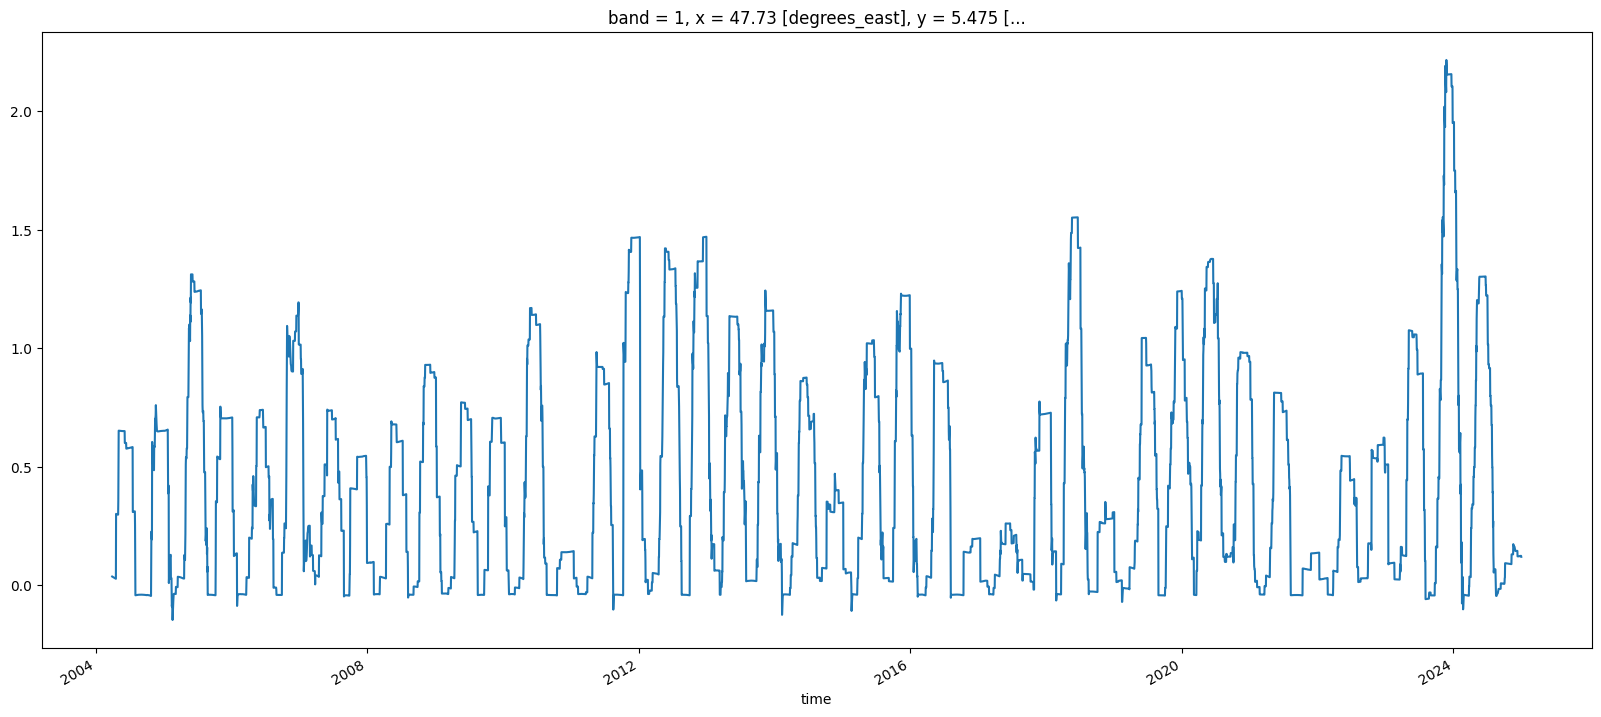

In [74]:
plt.figure(figsize=(20, 8))
smoothed_data['sma_90'].plot()

In [ ]:
   # Plot raw and smoothed P-ET
    plt.figure(figsize=(12, 8))
    # p_minus_et_raw.plot(label='Raw P-ET', color='gray', alpha=0.5)
    
    # Plot EMA
    for t in time_scales:
        smoothed_data['EMA'][t].plot(label=f'EMA ({t}-day)')
    
    # Plot SMA
    for t in time_scales:
        smoothed_data['SMA'][t].plot(label=f'SMA ({t}-day)', linestyle='--')
    
    plt.axhline(0, color='k', linestyle='--')
    plt.title(f"P-ET Smoothing Comparison (Subregion {subregion_id}, y={y}, x={x})")
    plt.xlabel("Time")
    plt.ylabel("P - ET")
    plt.legend()
    plt.show()

In [25]:
subregion_ma

{1: {'EMA': {90: <xarray.DataArray (time: 7671)>
   dask.array<sub, shape=(7671,), dtype=float64, chunksize=(7671,), chunktype=numpy.ndarray>
   Coordinates:
       band         int64 1
       x            float64 47.78
       y            float64 6.325
     * time         (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
       spatial_ref  int64 0
       lat          float64 dask.array<chunksize=(), meta=np.ndarray>
       lon          float64 dask.array<chunksize=(), meta=np.ndarray>,
   180: <xarray.DataArray (time: 7671)>
   dask.array<sub, shape=(7671,), dtype=float64, chunksize=(7671,), chunktype=numpy.ndarray>
   Coordinates:
       band         int64 1
       x            float64 47.78
       y            float64 6.325
     * time         (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
       spatial_ref  int64 0
       lat          float64 dask.array<chunksize=(), meta=np.ndarray>
       lon          float64 dask.array<chunksize=(), meta=np.ndarray>},
  'S

In [47]:
sbone = subregion_ma[4]['EMA'][90]

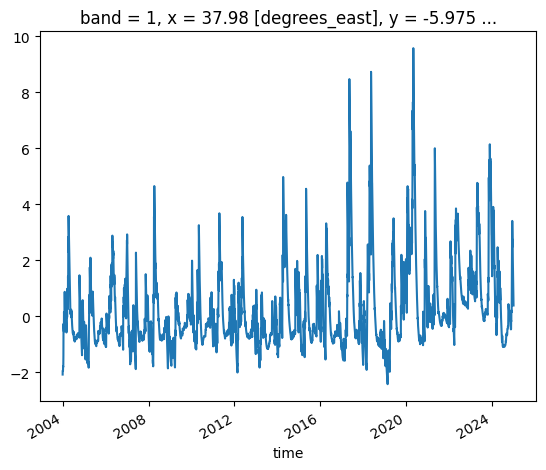

In [75]:
sbone.plot()

In [76]:
subregion_ma

{1: {'spei_3months': <xarray.DataArray 'spei' (time: 432)>
  [432 values with dtype=float32]
  Coordinates:
      lat      float32 5.475
      lon      float32 47.72
    * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2016-12-01
  Attributes:
      units:      z value
      long_name:  Standardized Precipitation Evapotranspiration Index,
  'ema_90': <xarray.DataArray (time: 7671)>
  dask.array<sub, shape=(7671,), dtype=float64, chunksize=(7671,), chunktype=numpy.ndarray>
  Coordinates:
      band         int64 1
      x            float64 47.73
      y            float64 5.475
    * time         (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
      spatial_ref  int64 0
      lat          float64 dask.array<chunksize=(), meta=np.ndarray>
      lon          float64 dask.array<chunksize=(), meta=np.ndarray>,
  'sma_90': <xarray.DataArray (time: 7671)>
  dask.array<sub, shape=(7671,), dtype=float64, chunksize=(589,), chunktype=numpy.ndarray>
  Coordinates:
      band 

In [60]:
time_scale = [90, 180, 360]

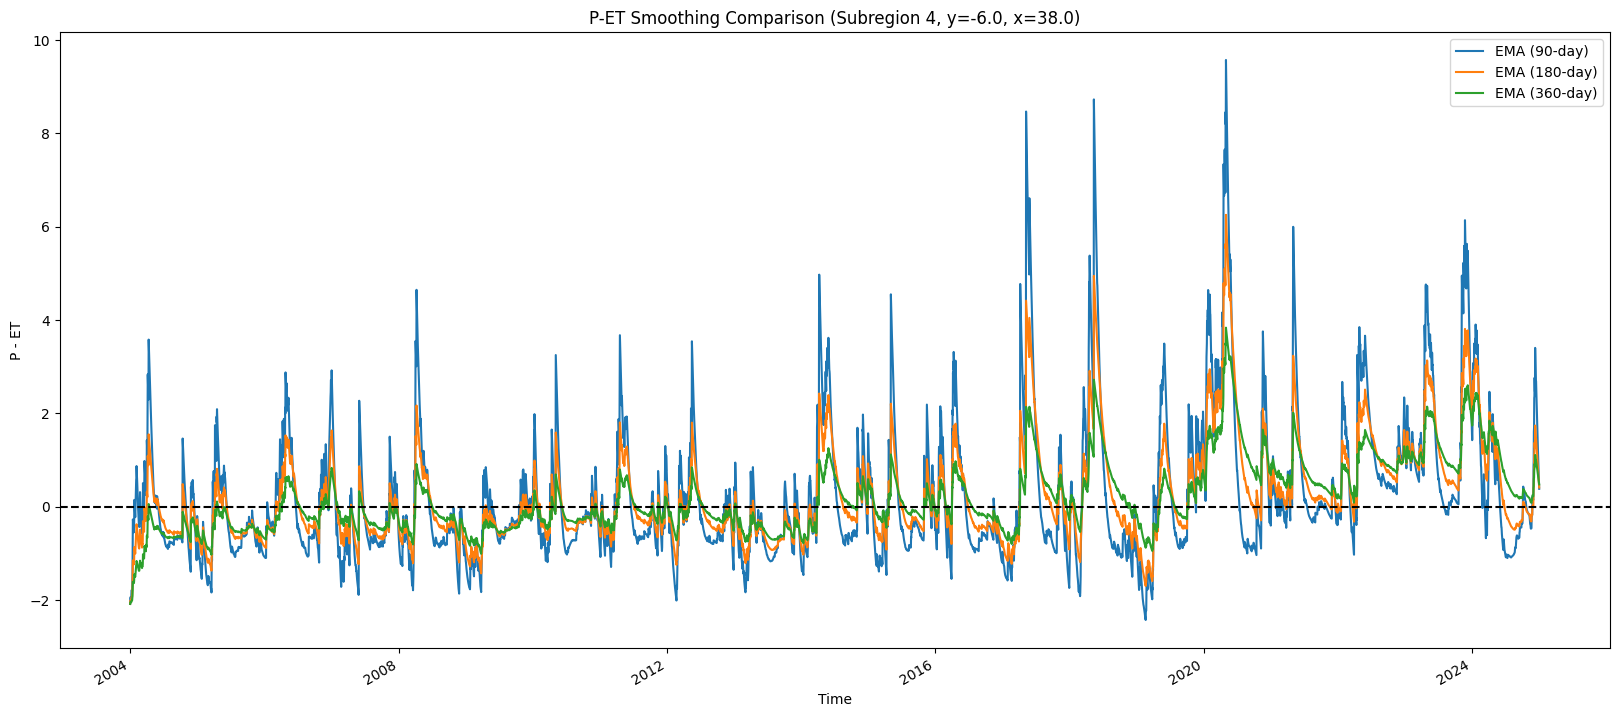

In [22]:
plt.figure(figsize=(20, 8))
    # p_minus_et_raw.plot(label='Raw P-ET', color='gray', alpha=0.5)
    
    # Plot EMA
for t in time_scales:
        smoothed_data['EMA'][t].plot(label=f'EMA ({t}-day)')
    
plt.axhline(0, color='k', linestyle='--')
plt.title(f"P-ET Smoothing Comparison (Subregion {subregion_id}, y={y}, x={x})")
plt.xlabel("Time")
plt.ylabel("P - ET")
plt.legend()
plt.show()

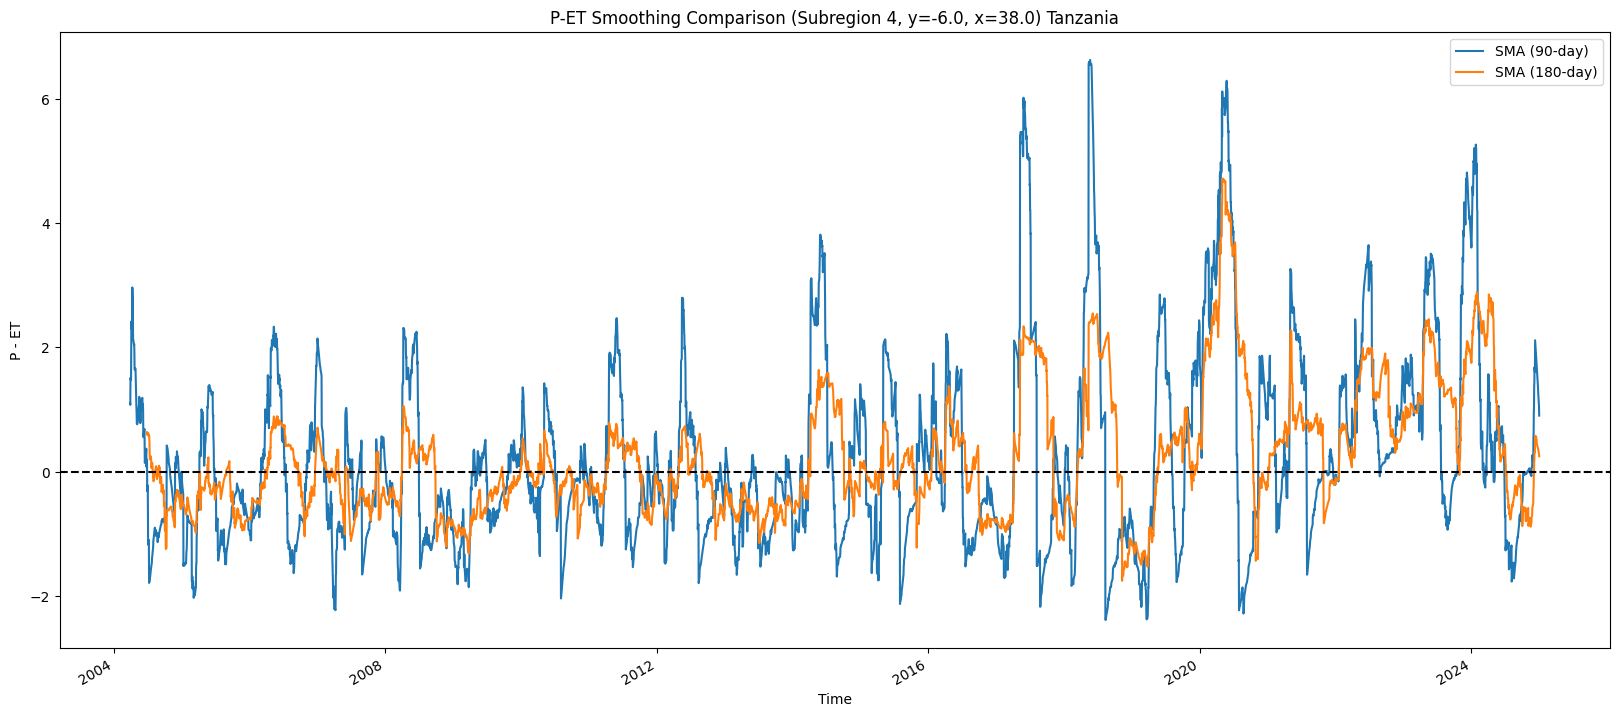

In [41]:
plt.figure(figsize=(20, 8))    
    # Plot SMA
for t in time_scale:
        smoothed_data['SMA'][t].plot(label=f'SMA ({t}-day)')
plt.axhline(0, color='k', linestyle='--')
plt.title(f"P-ET Smoothing Comparison (Subregion {subregion_id}, y={y}, x={x}) Tanzania")
plt.xlabel("Time")
plt.ylabel("P - ET")
plt.legend()
plt.show()

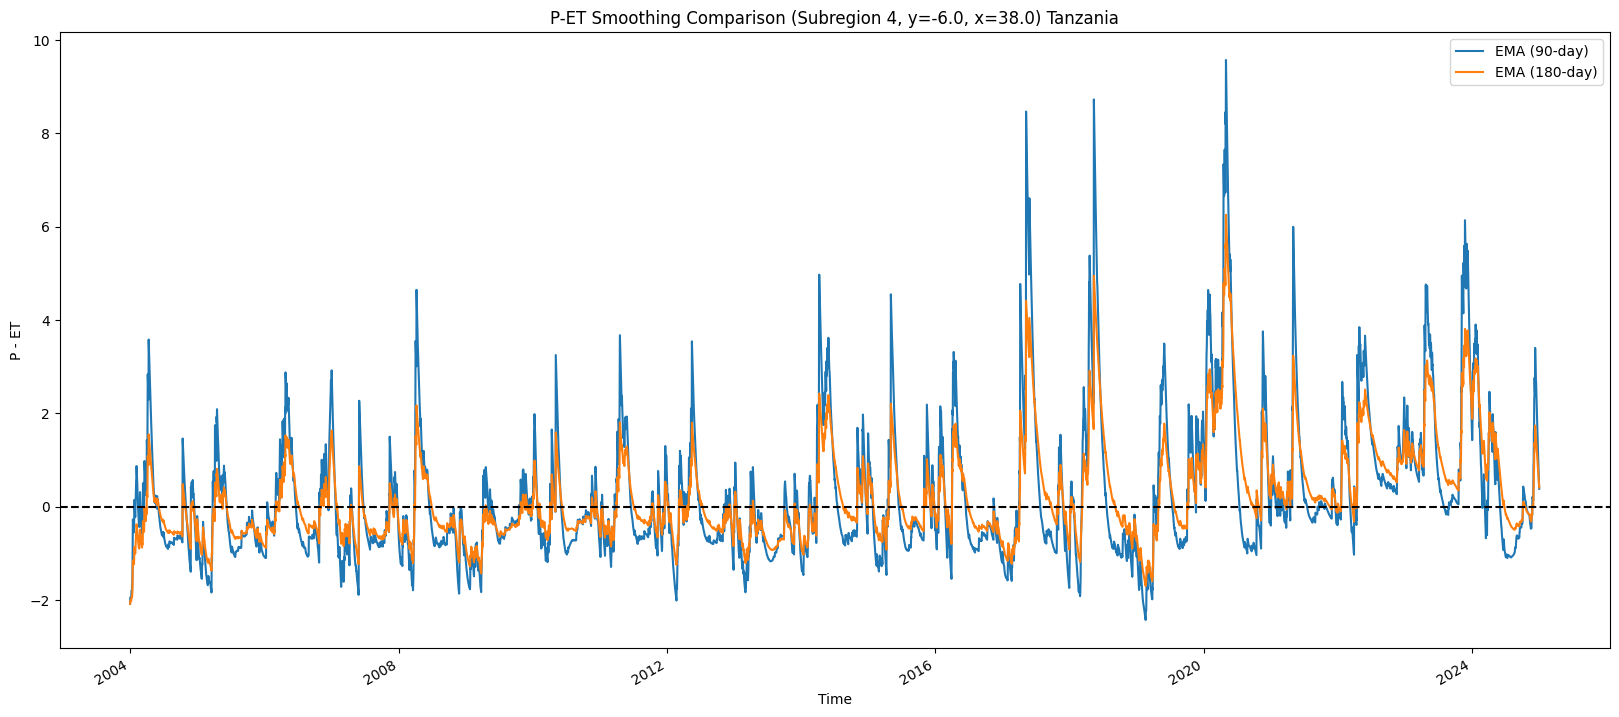

In [40]:
plt.figure(figsize=(20, 8))
    # p_minus_et_raw.plot(label='Raw P-ET', color='gray', alpha=0.5)
    
    # Plot EMA
for t in time_scale:
        smoothed_data['EMA'][t].plot(label=f'EMA ({t}-day)')
    
plt.axhline(0, color='k', linestyle='--')
plt.title(f"P-ET Smoothing Comparison (Subregion {subregion_id}, y={y}, x={x}) Tanzania")
plt.xlabel("Time")
plt.ylabel("P - ET")
plt.legend()
plt.show()

In [42]:
g = subregion_ma[1]['EMA']

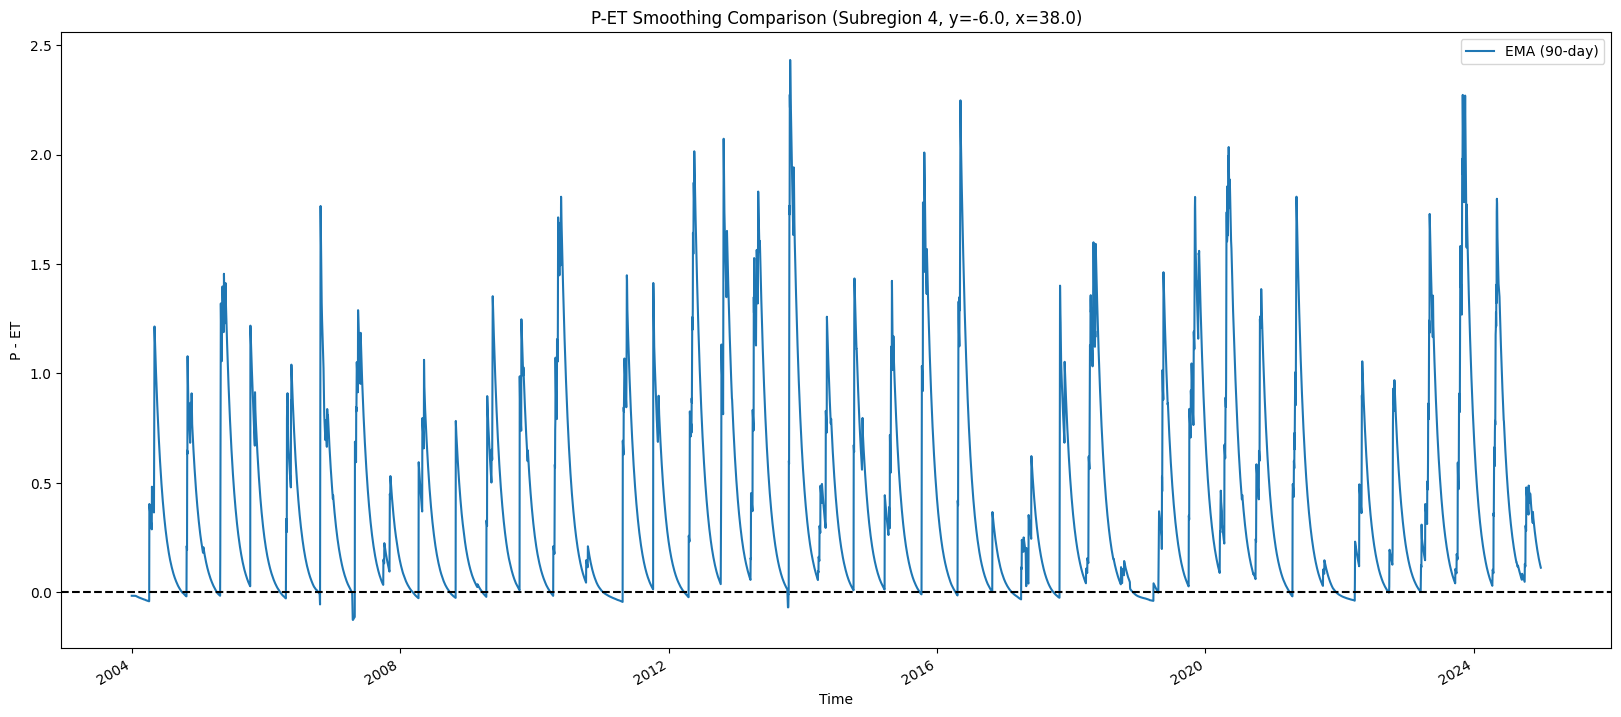

In [34]:
plt.figure(figsize=(20, 8))
    # p_minus_et_raw.plot(label='Raw P-ET', color='gray', alpha=0.5)
    
    # Plot EMA
for t in time_scale:
        g[t].plot(label=f'EMA ({t}-day)')
    
plt.axhline(0, color='k', linestyle='--')
plt.title(f"P-ET Smoothing Comparison (Subregion {subregion_id}, y={y}, x={x})")
plt.xlabel("Time")
plt.ylabel("P - ET")
plt.legend()
plt.show()

In [11]:
sub_one = spei.spei.sel(lon=representative_coords[subregion_id]['x'], lat=representative_coords[subregion_id]['y'], method='nearest')

In [38]:
sub_one

<xarray.DataArray 'spei' (time: 432)>
[432 values with dtype=float32]
Coordinates:
    lat      float32 -5.975
    lon      float32 38.03
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2016-12-01
Attributes:
    units:      z value
    long_name:  Standardized Precipitation Evapotranspiration Index

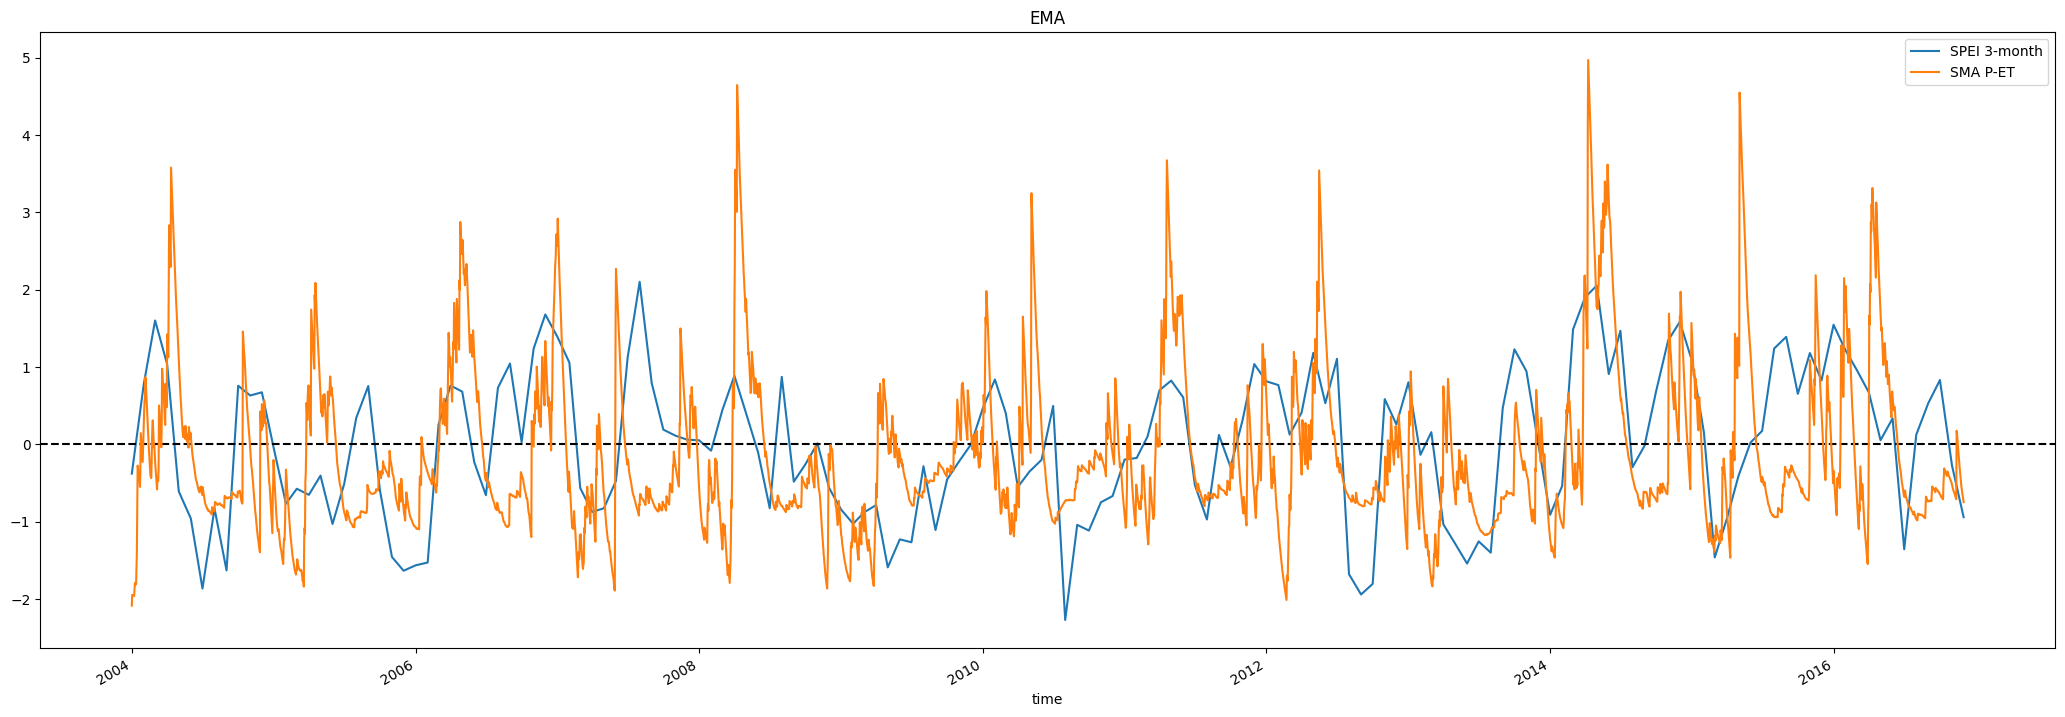

In [49]:
plt.figure(figsize=(26, 8))
sub_one.sel(time=slice('2004-01-01', None)).plot(label='SPEI 3-month')
plt.axhline(0, color='k', linestyle='--')
sbone.sel(time=slice('2004-01-01', '2016-12-01')).plot(label='SMA P-ET')
plt.title('EMA')
plt.legend()
plt.show()

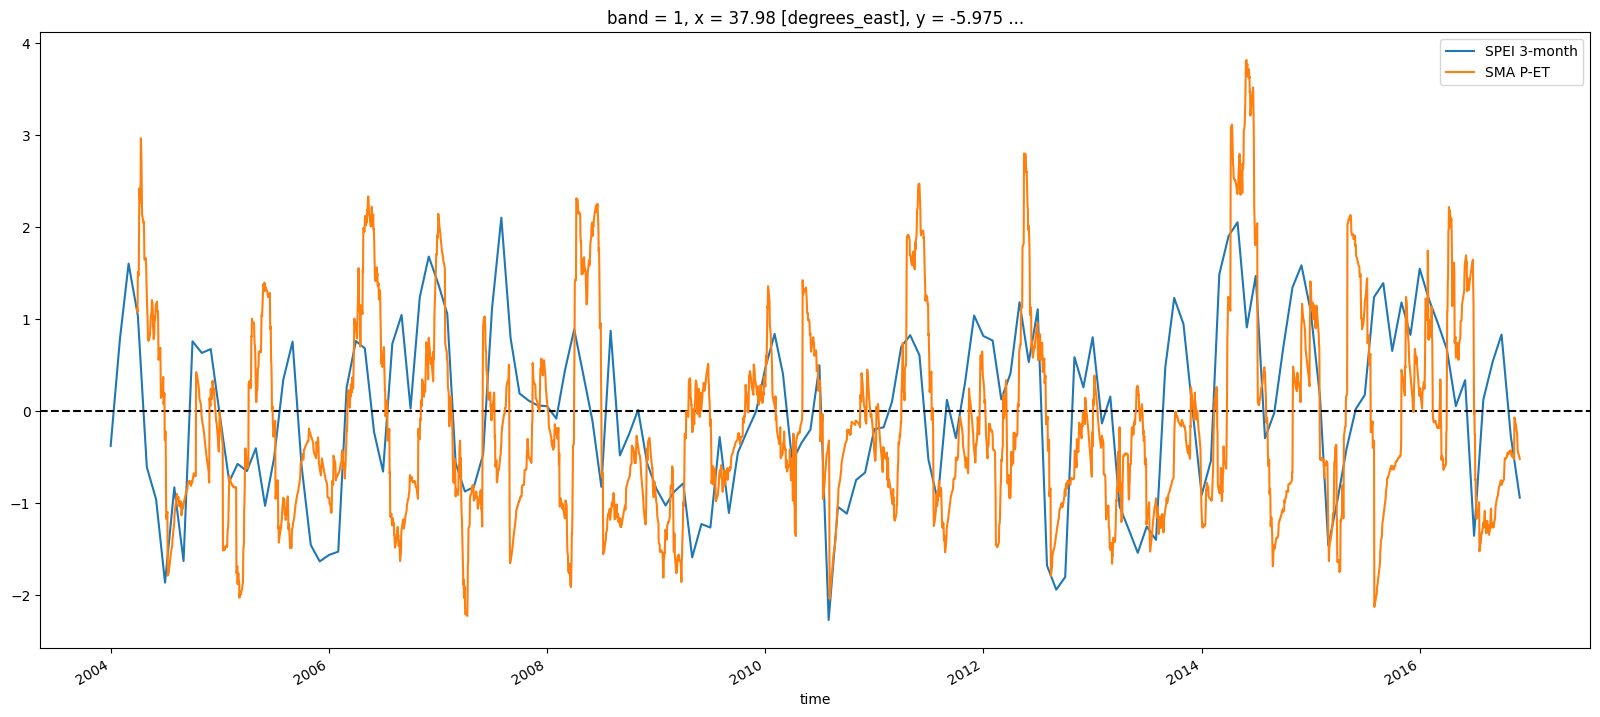

In [46]:
plt.figure(figsize=(20, 8))
sub_one.sel(time=slice('2004-01-01', None)).plot(label='SPEI 3-month')
plt.axhline(0, color='k', linestyle='--')
sbone.sel(time=slice('2004-01-01', '2016-12-01')).plot(label='SMA P-ET')
plt.legend()
plt.show()

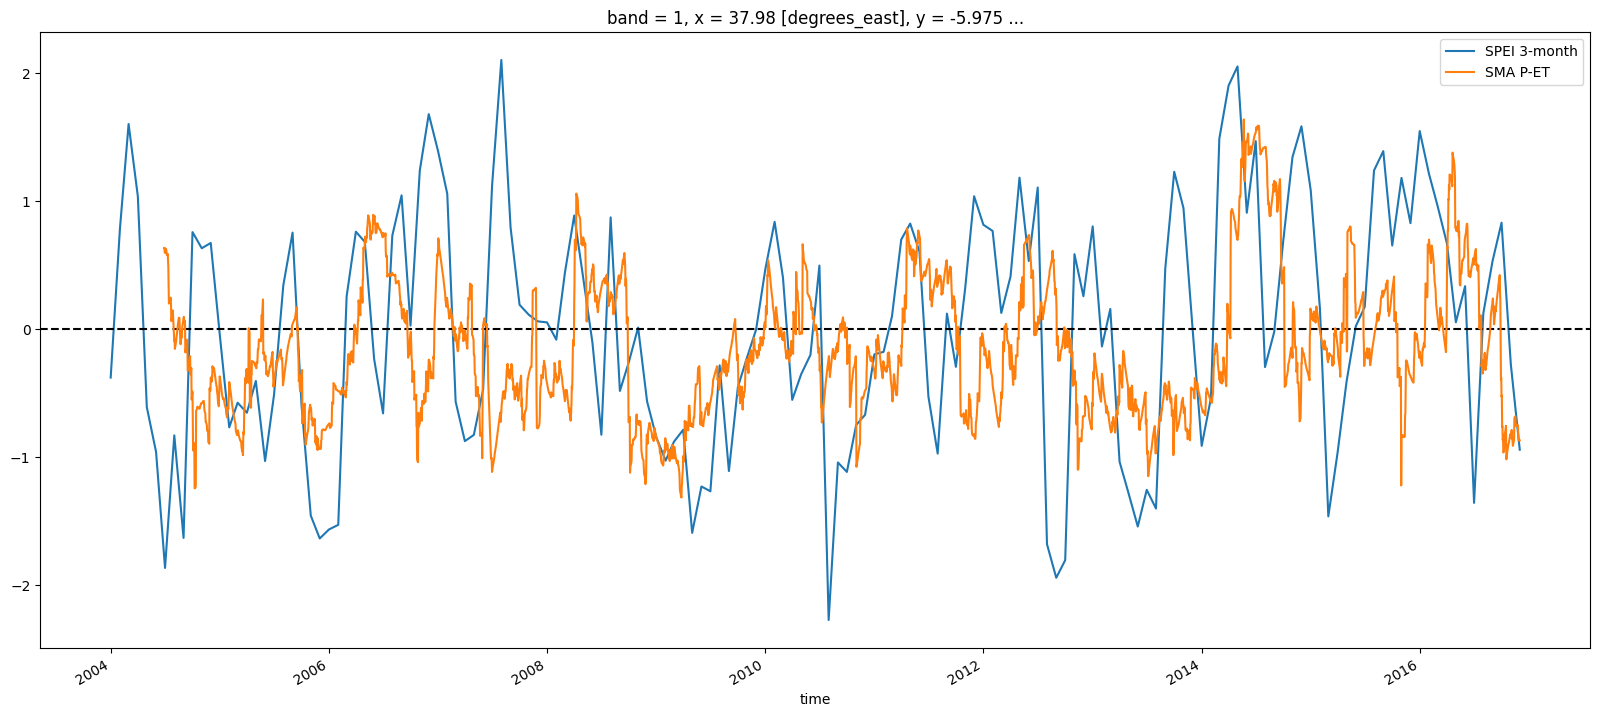

In [44]:
plt.figure(figsize=(20, 8))
sub_one.sel(time=slice('2004-01-01', None)).plot(label='SPEI 3-month')
plt.axhline(0, color='k', linestyle='--')
sbone.sel(time=slice('2004-01-01', '2016-12-01')).plot(label='SMA P-ET')
plt.legend()
plt.show()

In [31]:
representative_coords[subregion_id]['y']

-6.0

2025-04-25 17:25:17,164 - INFO - Processing subregion 1
2025-04-25 17:25:17,179 - INFO - Computing EMA for span 90 along dimension time
2025-04-25 17:25:17,183 - INFO - Computing EMA for span 90 along dimension time
2025-04-25 17:25:17,189 - INFO - Computing SMA for window 90 along dimension time
2025-04-25 17:25:17,223 - INFO - Computing SMA for window 90 along dimension time
2025-04-25 17:25:17,256 - INFO - Computing EMA for span 180 along dimension time
2025-04-25 17:25:17,259 - INFO - Computing EMA for span 180 along dimension time
2025-04-25 17:25:17,265 - INFO - Computing SMA for window 180 along dimension time
2025-04-25 17:25:17,298 - INFO - Computing SMA for window 180 along dimension time
2025-04-25 17:25:17,331 - INFO - Computing EMA for span 360 along dimension time
2025-04-25 17:25:17,335 - INFO - Computing EMA for span 360 along dimension time
2025-04-25 17:25:17,341 - INFO - Computing SMA for window 360 along dimension time
2025-04-25 17:25:17,373 - INFO - Computing SMA 

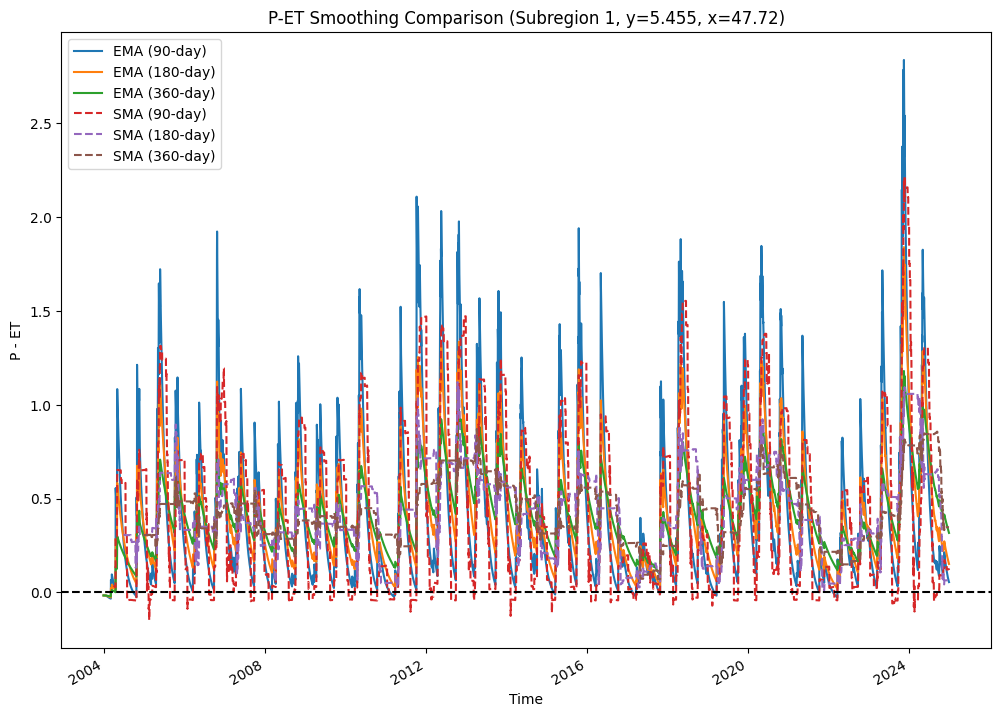

2025-04-25 17:25:38,391 - INFO - Processing subregion 2
2025-04-25 17:25:38,405 - INFO - Computing EMA for span 90 along dimension time
2025-04-25 17:25:38,408 - INFO - Computing EMA for span 90 along dimension time
2025-04-25 17:25:38,415 - INFO - Computing SMA for window 90 along dimension time
2025-04-25 17:25:38,446 - INFO - Computing SMA for window 90 along dimension time
2025-04-25 17:25:38,480 - INFO - Computing EMA for span 180 along dimension time
2025-04-25 17:25:38,483 - INFO - Computing EMA for span 180 along dimension time
2025-04-25 17:25:38,488 - INFO - Computing SMA for window 180 along dimension time
2025-04-25 17:25:38,520 - INFO - Computing SMA for window 180 along dimension time
2025-04-25 17:25:38,553 - INFO - Computing EMA for span 360 along dimension time
2025-04-25 17:25:38,556 - INFO - Computing EMA for span 360 along dimension time
2025-04-25 17:25:38,561 - INFO - Computing SMA for window 360 along dimension time
2025-04-25 17:25:38,593 - INFO - Computing SMA 

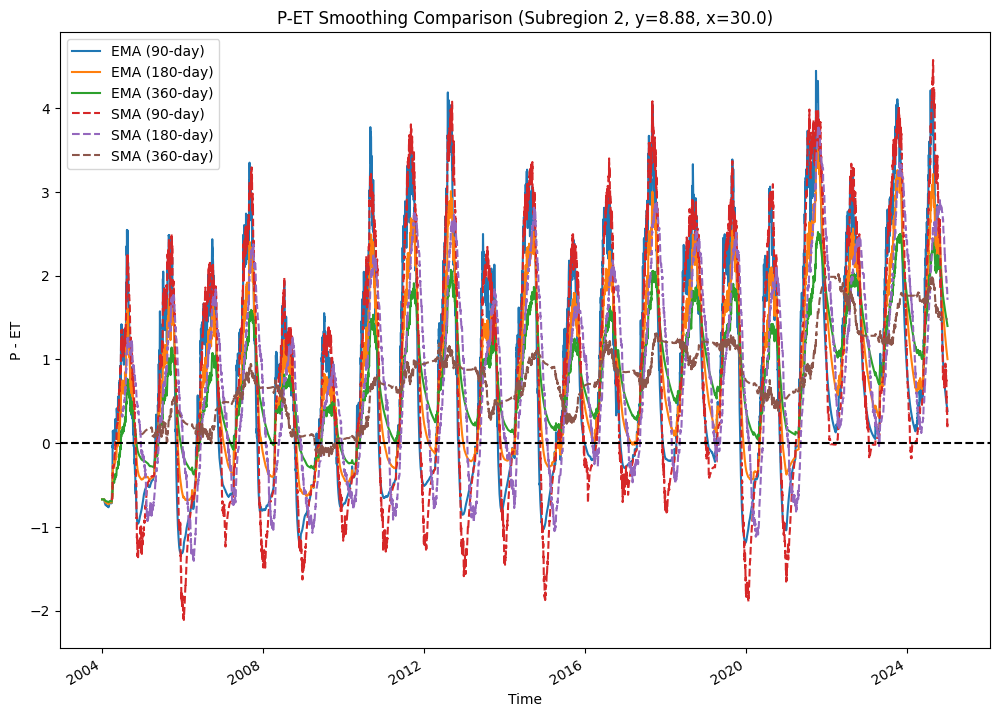

2025-04-25 17:25:59,337 - INFO - Processing subregion 3
2025-04-25 17:25:59,351 - INFO - Computing EMA for span 90 along dimension time
2025-04-25 17:25:59,356 - INFO - Computing EMA for span 90 along dimension time
2025-04-25 17:25:59,361 - INFO - Computing SMA for window 90 along dimension time
2025-04-25 17:25:59,393 - INFO - Computing SMA for window 90 along dimension time
2025-04-25 17:25:59,426 - INFO - Computing EMA for span 180 along dimension time
2025-04-25 17:25:59,429 - INFO - Computing EMA for span 180 along dimension time
2025-04-25 17:25:59,435 - INFO - Computing SMA for window 180 along dimension time
2025-04-25 17:25:59,467 - INFO - Computing SMA for window 180 along dimension time
2025-04-25 17:25:59,500 - INFO - Computing EMA for span 360 along dimension time
2025-04-25 17:25:59,503 - INFO - Computing EMA for span 360 along dimension time
2025-04-25 17:25:59,509 - INFO - Computing SMA for window 360 along dimension time
2025-04-25 17:25:59,542 - INFO - Computing SMA 

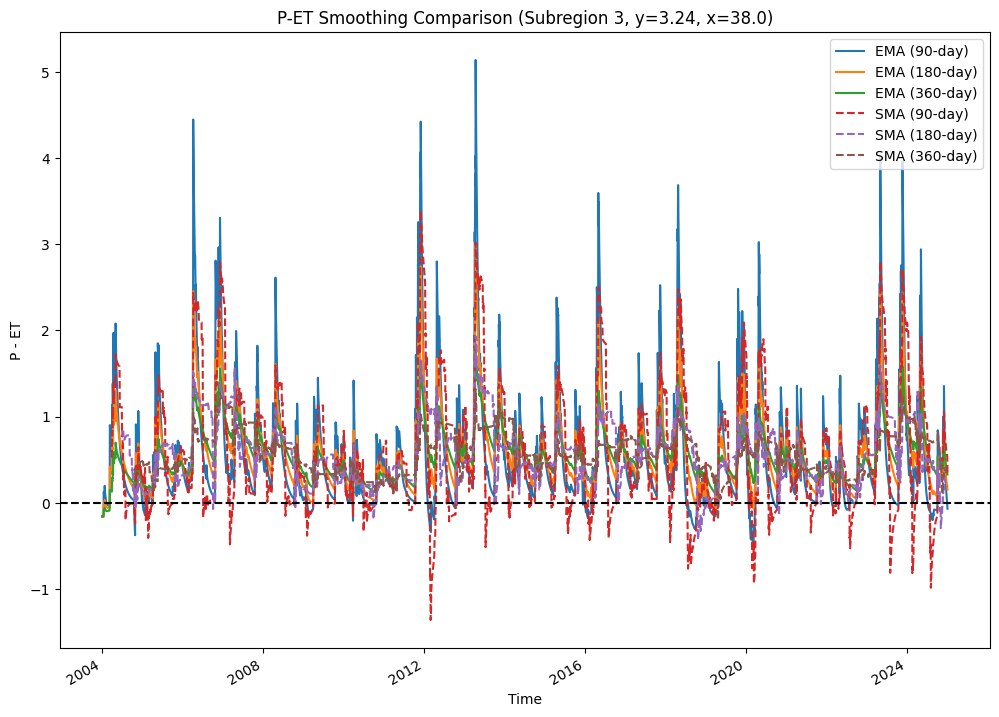

2025-04-25 17:26:20,021 - INFO - Processing subregion 4
2025-04-25 17:26:20,034 - INFO - Computing EMA for span 90 along dimension time
2025-04-25 17:26:20,039 - INFO - Computing EMA for span 90 along dimension time
2025-04-25 17:26:20,044 - INFO - Computing SMA for window 90 along dimension time
2025-04-25 17:26:20,076 - INFO - Computing SMA for window 90 along dimension time
2025-04-25 17:26:20,109 - INFO - Computing EMA for span 180 along dimension time
2025-04-25 17:26:20,112 - INFO - Computing EMA for span 180 along dimension time
2025-04-25 17:26:20,117 - INFO - Computing SMA for window 180 along dimension time
2025-04-25 17:26:20,149 - INFO - Computing SMA for window 180 along dimension time
2025-04-25 17:26:20,182 - INFO - Computing EMA for span 360 along dimension time
2025-04-25 17:26:20,185 - INFO - Computing EMA for span 360 along dimension time
2025-04-25 17:26:20,191 - INFO - Computing SMA for window 360 along dimension time
2025-04-25 17:26:20,223 - INFO - Computing SMA 

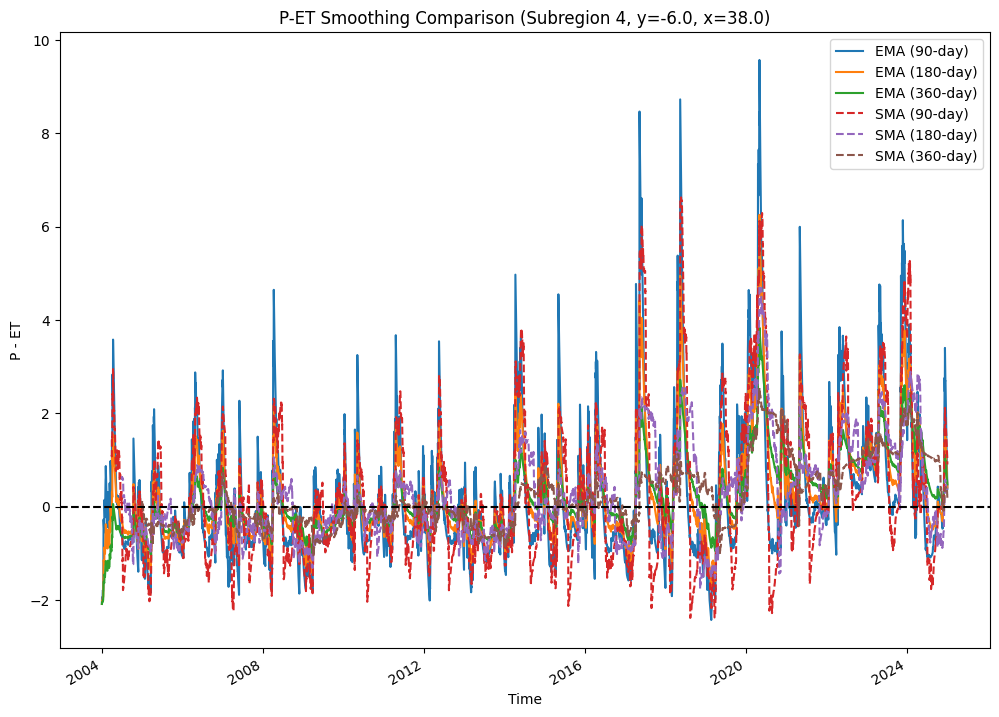

In [43]:
# Define representative coordinates for each subregion
representative_coords = {
    1: {'y': 5.455, 'x': 47.72}, # Somalia 5.450490729683283, 47.72290023096062
    2: {'y': 8.88, 'x': 30.0},
    3: {'y': 3.24, 'x': 38.0}, # Northern Kenya
    4: {'y': -6.0, 'x': 38.0}, # Tanzania
}

subregion_ma = {}

# Define time scales (90, 180, 360 days)
time_scales = [90, 180, 360]

# Process each subregion
for subregion_id, ds in subregion_datasets.items():
    logging.info(f"Processing subregion {subregion_id}")
    
    # Select representative grid point
    y, x = representative_coords[subregion_id]['y'], representative_coords[subregion_id]['x']
    ds_point = ds.sel(y=y, x=x, method='nearest')
    
    # Compute P-ET (raw)
    p_minus_et_raw = ds_point['precipitation'] - ds_point['et']
    
    # Dictionary to store smoothed P-ET for different methods and time scales
    smoothed_data = {'EMA': {}, 'SMA': {}}
    
    # Compute EMA and SMA for each time scale
    for t in time_scales:
        # EMA
        precip_ema = compute_ema_dask(ds_point['precipitation'], span=t)
        et_ema = compute_ema_dask(ds_point['et'], span=t)
        smoothed_data['EMA'][t] = precip_ema - et_ema
        
        # SMA
        precip_sma = compute_sma(ds_point['precipitation'], window=t)
        et_sma = compute_sma(ds_point['et'], window=t)
        smoothed_data['SMA'][t] = precip_sma - et_sma
        
        subregion_ma[subregion_id] = smoothed_data
    
    # Plot raw and smoothed P-ET
    plt.figure(figsize=(12, 8))
    # p_minus_et_raw.plot(label='Raw P-ET', color='gray', alpha=0.5)
    
    # Plot EMA
    for t in time_scales:
        smoothed_data['EMA'][t].plot(label=f'EMA ({t}-day)')
    
    # Plot SMA
    for t in time_scales:
        smoothed_data['SMA'][t].plot(label=f'SMA ({t}-day)', linestyle='--')
    
    plt.axhline(0, color='k', linestyle='--')
    plt.title(f"P-ET Smoothing Comparison (Subregion {subregion_id}, y={y}, x={x})")
    plt.xlabel("Time")
    plt.ylabel("P - ET")
    plt.legend()
    plt.show()

In [84]:
k

<xarray.DataArray 'tws' (time: 7671)>
dask.array<getitem, shape=(7671,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
    x            float64 47.73
    y            float64 5.475
  * time         (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref  int64 0
    lat          float64 dask.array<chunksize=(), meta=np.ndarray>
    lon          float64 dask.array<chunksize=(), meta=np.ndarray>

In [56]:
gw = subregion_ma[1]['EMA']

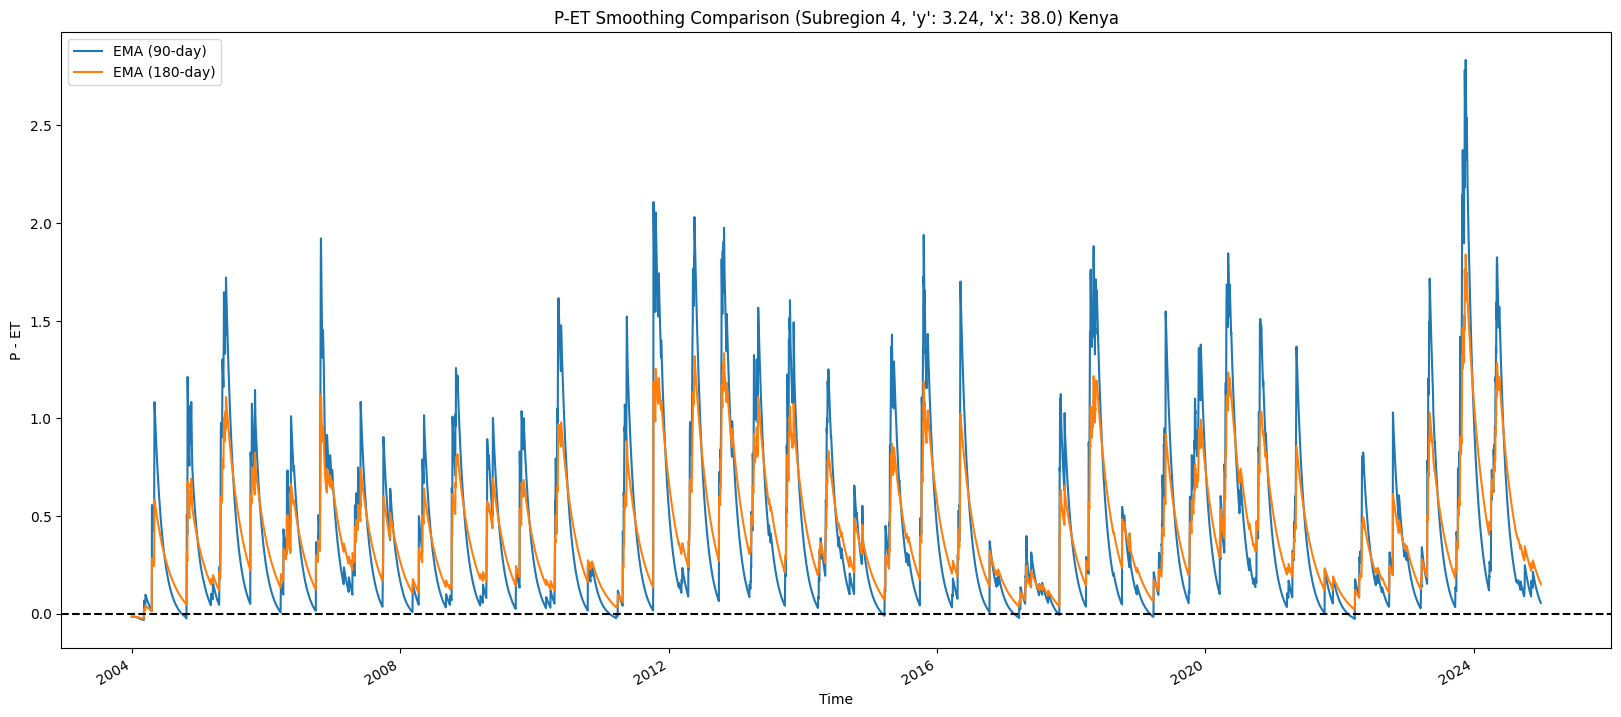

In [57]:
plt.figure(figsize=(20, 8))
    # p_minus_et_raw.plot(label='Raw P-ET', color='gray', alpha=0.5)
    
    # Plot EMA
for t in time_scale:
        gw[t].plot(label=f'EMA ({t}-day)')
    
plt.axhline(0, color='k', linestyle='--')
plt.title(f"P-ET Smoothing Comparison (Subregion {subregion_id}, 'y': 3.24, 'x': 38.0) Kenya")
plt.xlabel("Time")
plt.ylabel("P - ET")
plt.legend()
plt.show()

In [54]:
y

-6.0

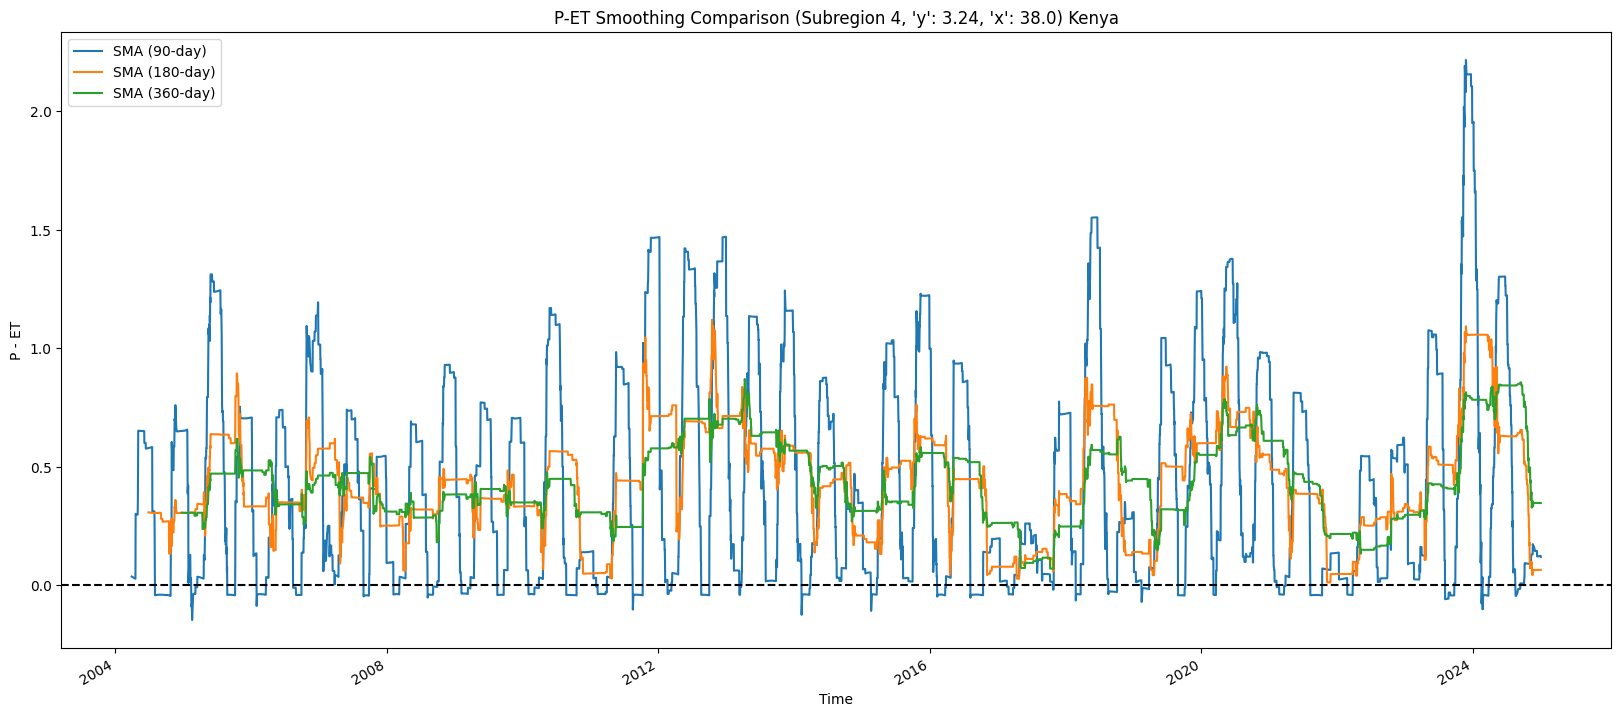

In [61]:
gwe = subregion_ma[1]['SMA']
plt.figure(figsize=(20, 8))
    # p_minus_et_raw.plot(label='Raw P-ET', color='gray', alpha=0.5)
    
    # Plot EMA
for t in time_scale:
        gwe[t].plot(label=f'SMA ({t}-day)')
    
plt.axhline(0, color='k', linestyle='--')
plt.title(f"P-ET Smoothing Comparison (Subregion {subregion_id}, 'y': 3.24, 'x': 38.0) Kenya")
plt.xlabel("Time")
plt.ylabel("P - ET")
plt.legend()
plt.show()

In [90]:
 gwe[360]

<xarray.DataArray (time: 7671)>
dask.array<sub, shape=(7671,), dtype=float64, chunksize=(859,), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
    x            float64 47.73
    y            float64 5.475
  * time         (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref  int64 0
    lat          float64 dask.array<chunksize=(), meta=np.ndarray>
    lon          float64 dask.array<chunksize=(), meta=np.ndarray>

In [63]:
gws = subregion_ma[1]['EMA']

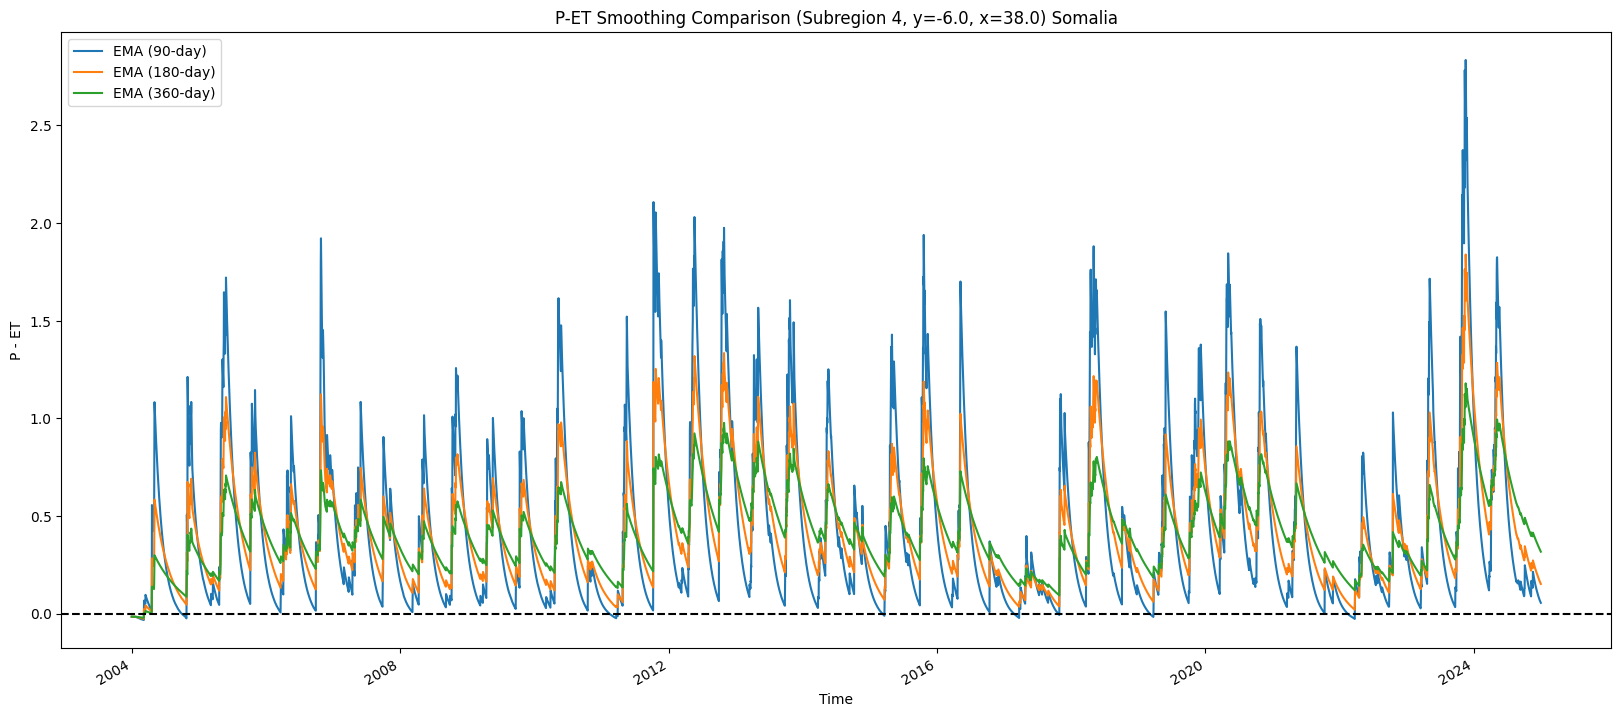

In [64]:
plt.figure(figsize=(20, 8))
    # p_minus_et_raw.plot(label='Raw P-ET', color='gray', alpha=0.5)
    
    # Plot EMA
for t in time_scale:
        gws[t].plot(label=f'EMA ({t}-day)')
    
plt.axhline(0, color='k', linestyle='--')
plt.title(f"P-ET Smoothing Comparison (Subregion {subregion_id}, y={y}, x={x}) Somalia")
plt.xlabel("Time")
plt.ylabel("P - ET")
plt.legend()
plt.show()

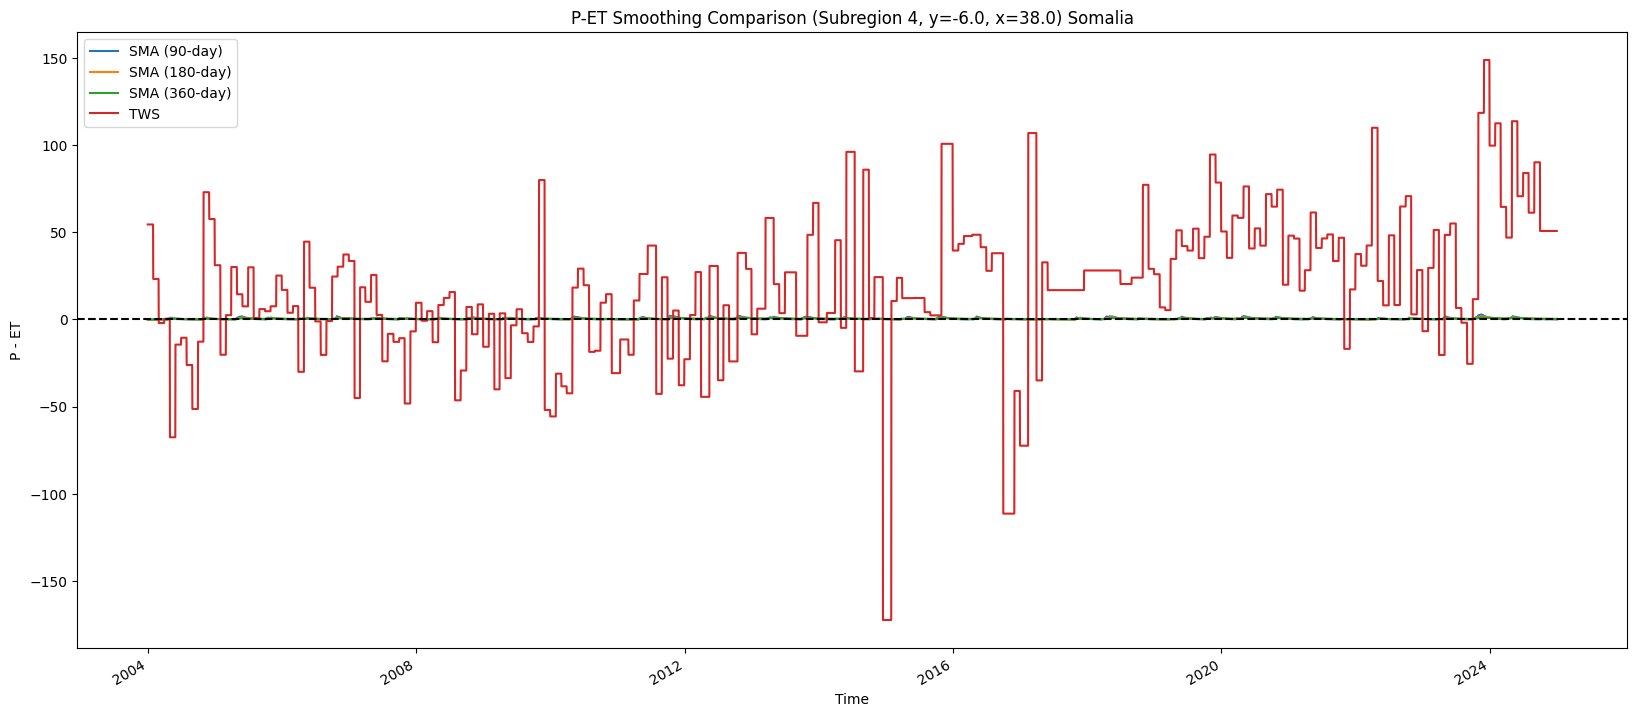

In [83]:
plt.figure(figsize=(20, 8))
    # p_minus_et_raw.plot(label='Raw P-ET', color='gray', alpha=0.5)
    
    # Plot EMA
for t in time_scale:
        gws[t].plot(label=f'SMA ({t}-day)')
k.plot(label='TWS')

    
plt.axhline(0, color='k', linestyle='--')
plt.title(f"P-ET Smoothing Comparison (Subregion {subregion_id}, y={y}, x={x}) Somalia")
plt.xlabel("Time")
plt.ylabel("P - ET")
plt.legend()
plt.show()

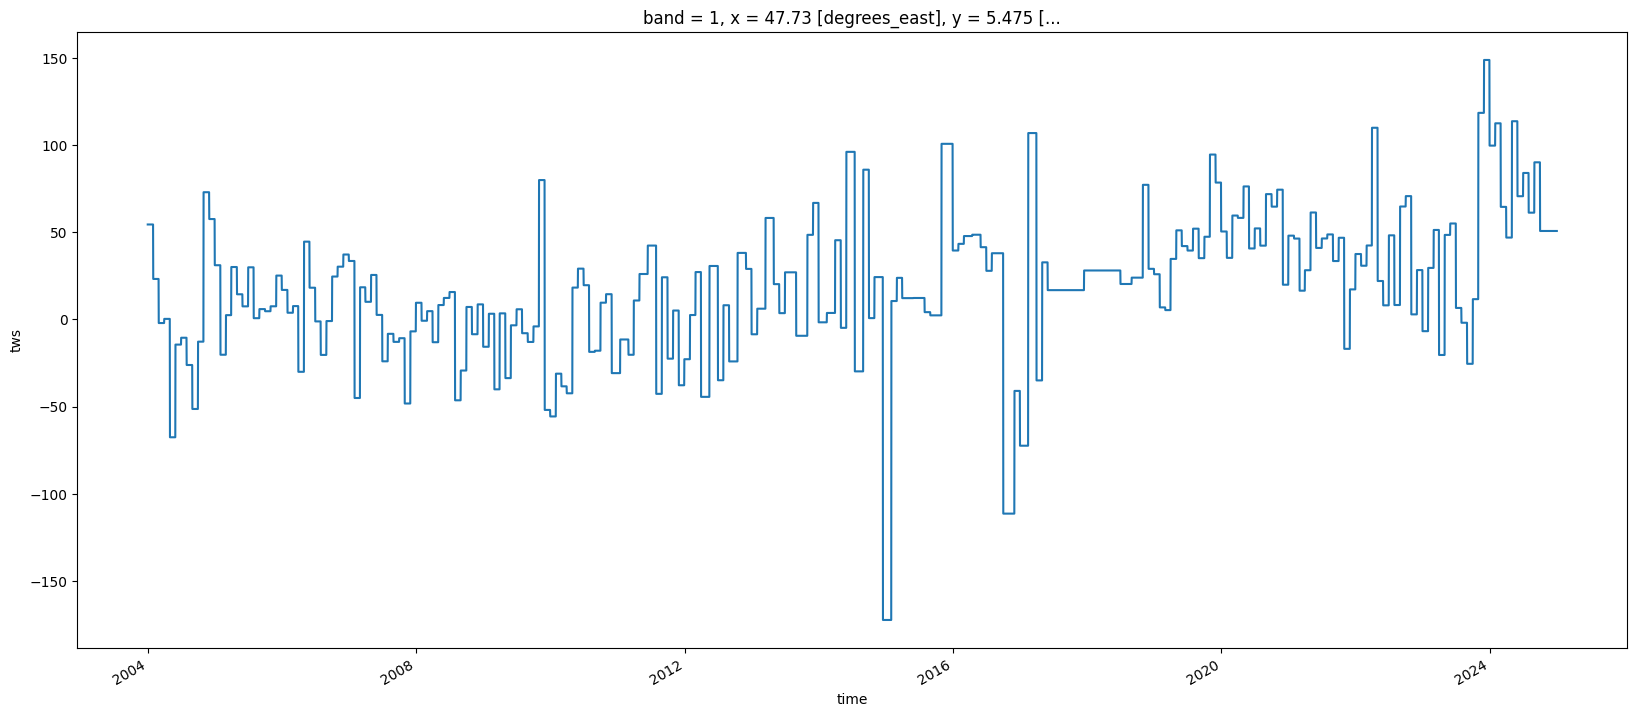

In [82]:
plt.figure(figsize=(20, 8))
    # p_minus_et_raw.plot(label='Raw P-ET', color='gray', alpha=0.5)
    

k.plot(label='TWS')


In [67]:
len(subregion_ma[3]['SMA'][90].values)

7671

In [70]:
# Define representative coordinates for each subregion
representative_coords = {
    1: {'y': 5.455, 'x': 47.72}, # Somalia 5.450490729683283, 47.72290023096062
    2: {'y': 8.88, 'x': 30.0},
    3: {'y': 3.24, 'x': 38.0}, # Northern Kenya
    4: {'y': -6.0, 'x': 38.0}, # Tanzania
}

In [80]:
zone_4 = subregion_datasets[1]
print(zone_4)

<xarray.Dataset>
Dimensions:        (time: 7671, y: 671, x: 337)
Coordinates:
    band           int64 1
  * x              (x) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 0
    lat            (y) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    lon            (x) float64 dask.array<chunksize=(44,), meta=np.ndarray>
Data variables:
    precipitation  (time, y, x) float32 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
    et             (time, y, x) float64 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
    tws            (time, y, x) float64 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
    p_ema120       (time, y, x) float32 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
    et_ema120      (time, y, x) float64 dask.array<chunksize=(500, 172, 44), meta=np.nda

In [81]:
k = zone_4.tws.sel(y=representative_coords[1]['y'], x=representative_coords[1]['x'], method='nearest')

In [ ]:
# # Option 2: Take a random sample (better for large datasets)
# sample_size = 800000  # adjust as needed
# random_idx = np.random.choice(len(tws_all), size=sample_size, replace=False)
tws_sample = zone_1_stacked['tws'].sel(y=5, x=47.76, method='nearest').values
p_et_sample = zone_1_stacked['pet'].sel(y=5, x=47.76, method='nearest').values

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tws_sample, p_et_sample, s=5)  # alpha for transparency, s for point size

# Add labels and title
plt.xlabel('TWS')
plt.ylabel('P-ET')
plt.title('Scatter Plot: TWS vs P-ET')

# Add grid
plt.grid(True, alpha=0.3)

plt.show()

## Observations
- **Raw P-ET (gray)**: Shows high variability, with frequent seasonal fluctuations.
- **EMA (solid lines)**: Gives more weight to recent values, resulting in quicker responses to changes but potentially missing cumulative effects over longer periods.
- **SMA (dashed lines)**: Equally weights all values in the window, providing a smoother curve that may better capture cumulative drought effects, especially with longer windows (e.g., 360 days).
- **Time Scales**: Longer windows (e.g., 360 days) reduce noise but may delay detection of drought onset. Shorter windows (e.g., 90 days) retain more variability but might not distinguish true droughts from seasonal dry periods.

## Next Steps
1. **Compare with SPI**: Overlay SPI (3-, 6-, or 12-month) to validate which smoothing method and time scale best identify true drought events.
2. **Adjust Time Scales**: Experiment with other windows (e.g., 120, 240 days) if needed.
3. **Scale Up**: If a specific method (e.g., SMA with 360-day window) looks promising, apply it to the full dataset.
4. **Copula Modeling**: Use the best smoothed P-ET with TWS in a copula model to improve drought detection.

In [ ]:
# Normalize raw data by subtracting mean and dividing by standard deviation

stats_dict = {}
normalized_dict = {}
for var in ['precipitation', 'et', 'pet', 'tws']:
    
    data = zone_1[var].compute()
    mean = data.mean().compute()
    std = data.std().compute()
    mean = float(mean)
    std = float(std)
    #std = max(std, 1e-6)  # Avoid division by zero
    stats_dict[var] = {'mean': mean, 'std': std}  
    print(f"Statistics for {var}: mean={mean:.4f}, std={std:.4f}")

    # Normalize: (data - mean) / std
    normalized_data = (data - mean) / std
    normalized_dict[var] = normalized_data

In [85]:
mean = k.mean()
std = k.std()
norm_tws = (k - mean) / std

In [92]:
l =  gwe[360]
mean = l.mean()
std = l.std()
norm_pet = (l - mean) / std

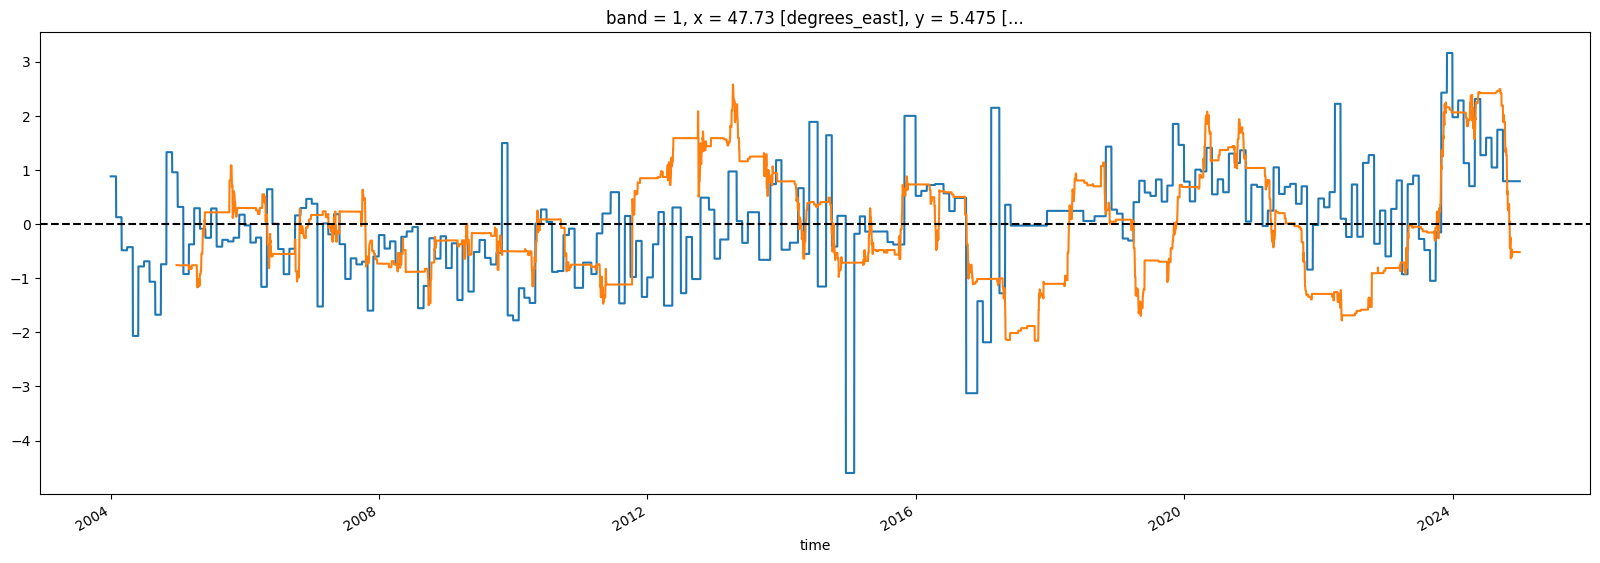

In [97]:
plt.figure(figsize = (20, 6))
norm_tws.plot()
norm_pet.plot()
plt.axhline(0, color='k', linestyle='--')
plt.show()

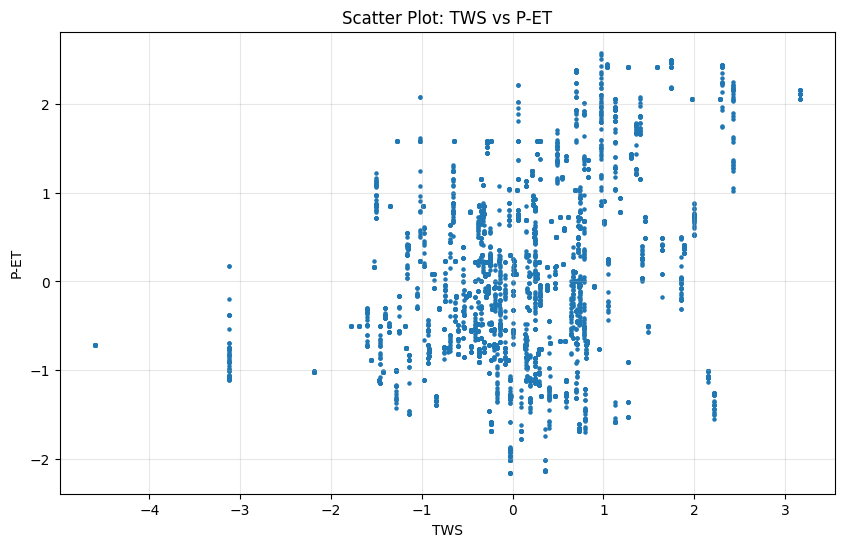

In [100]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(norm_tws, norm_pet, s=5)  # alpha for transparency, s for point size

# Add labels and title
plt.xlabel('TWS')
plt.ylabel('P-ET')
plt.title('Scatter Plot: TWS vs P-ET')

# Add grid
plt.grid(True, alpha=0.3)

plt.show()

In [101]:
# Create a common mask where all variables are non-NaN

common_mask = k.notnull().all()
# valid_data = stacked_data.where(common_mask, drop=True)


In [125]:
mask = (~np.isnan(norm_tws) & ~np.isnan(norm_pet))
pet_data = norm_pet[mask]
tws_data = norm_tws[mask]

In [128]:
pt = pet_data.compute()
tw = tws_data.compute()

In [118]:
len(~np.isnan(norm_pet.values))

7671

In [126]:
np.sort(norm_pet.values)

array([-2.15650737, -2.15643753, -2.15638412, ...,         nan,
               nan,         nan])

In [127]:
np.sort(pet_data.values)

array([-2.15650737, -2.15643753, -2.15638412, ...,  2.50766493,
        2.54746547,  2.57783709])

In [131]:
tcd = ECDF(tw)
pcd = ECDF(pt)

pmar = pcd(pt)
tmar = tcd(tw)

In [140]:
copula_data = np.column_stack([pmar, tmar])

Copula data shape: (7312, 2)


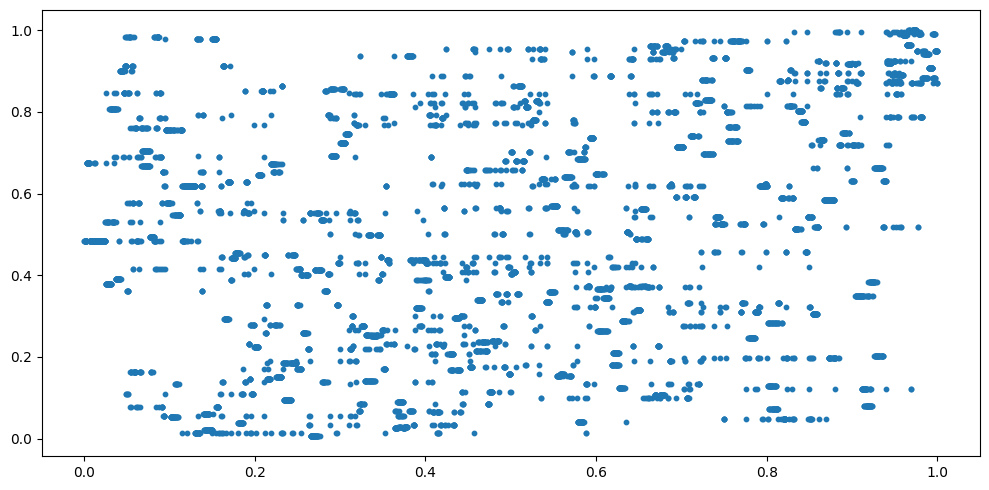

In [141]:
print(f"Copula data shape: {copula_data.shape}")  # Should be (200, 3)
# Visualize dependence
plt.figure(figsize=(10, 5))
plt.scatter(copula_data[:, 0], copula_data[:, 1], s=10)
# plt.set_xlabel('P-ET')
# plt.set_ylabel('TWS')

plt.tight_layout()
plt.show()

In [ ]:
plt

In [142]:
subregion_id = 1

# Define Copulas (assuming these are from a library like 'copulae')
copulas = {
    'Gaussian': GaussianCopula(dim=2),
    'Clayton': ClaytonCopula(dim=2),
    'Frank': FrankCopula(dim=2),
    'Gumbel': GumbelCopula(dim=2),
    'tCopula': StudentCopula(dim=2)
}

# Fit Copulas
results = {}
for name, copula in copulas.items():
    try:
        print(f'Fitting {name}...')
        copula.fit(copula_data)  # Assuming copula_data is defined elsewhere
        log_likelihood = copula.log_lik(copula_data)
        # Calculate AIC: -2 * log_likelihood + 2 * number_of_parameters
        num_params = copula.dim  # Adjust based on your copula library's parameter count
        aic = -2 * log_likelihood + 2 * num_params
        results[name] = {'copula': copula, 'log_likelihood': log_likelihood, 'AIC': aic}
        print(f"{name} Copula fitted for subregion {subregion_id}, log-likelihood: {log_likelihood:.2f}")
    except Exception as e:
        print(f"Failed to fit {name} Copula: {e}")

# Select best copula
if results:
    best_copula_name = max(results, key=lambda x: results[x]['log_likelihood'])  # Fixed key
    best_copula = results[best_copula_name]['copula']
    print(f"Best copula (by AIC): {best_copula_name} (AIC: {results[best_copula_name]['AIC']:.2f})")
else:
    print("No copulas were successfully fitted to the data.")

Fitting Gaussian...
Gaussian Copula fitted for subregion 1, log-likelihood: 283.95
Fitting Clayton...
Clayton Copula fitted for subregion 1, log-likelihood: 30.56
Fitting Frank...
Frank Copula fitted for subregion 1, log-likelihood: 235.69
Fitting Gumbel...
Gumbel Copula fitted for subregion 1, log-likelihood: 449.86
Fitting tCopula...
tCopula Copula fitted for subregion 1, log-likelihood: 290.17
Best copula (by AIC): Gumbel (AIC: -895.72)


In [152]:
sample = best_copula.random(10000)

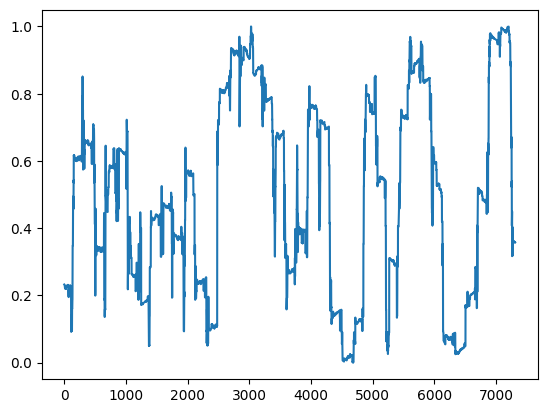

In [145]:
plt.plot(pmar)

Copula data shape: (7312, 2)


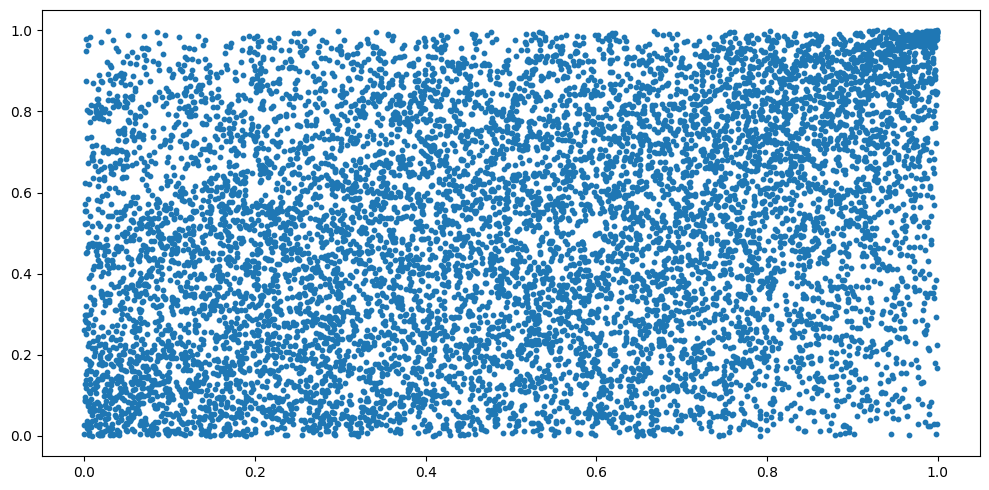

In [153]:
print(f"Copula data shape: {copula_data.shape}")  # Should be (200, 3)
# Visualize dependence
plt.figure(figsize=(10, 5))
plt.scatter(sample[:, 0], sample[:, 1], s=10)
# plt.set_xlabel('P-ET')
# plt.set_ylabel('TWS')

plt.tight_layout()
plt.show()